In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
data = pd.read_csv(Path.home()/'data'/'keypoints'/'training.csv')

In [4]:
data.shape

(7049, 31)

In [5]:
img_sz = 96
np_shape = img_sz, img_sz
torch_shape = 1, img_sz, img_sz
num_of_landmarks = 30
seed = 1

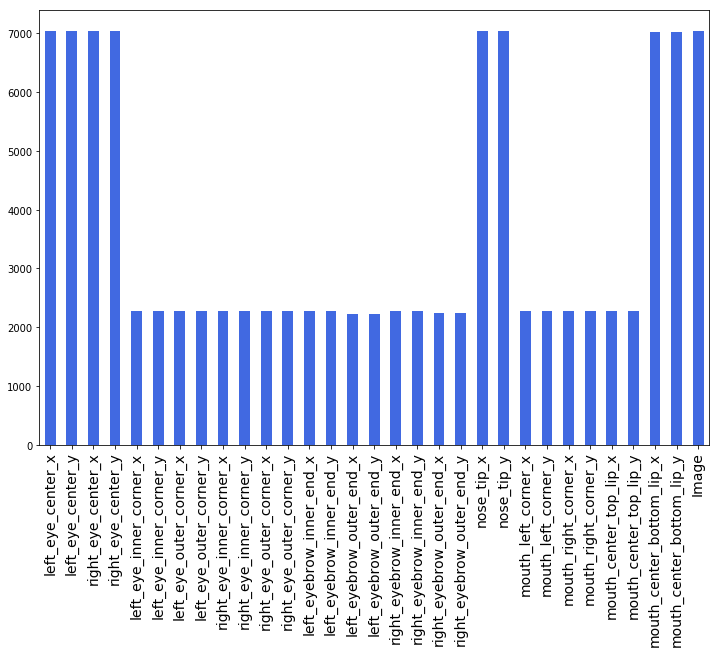

In [6]:
ax = data.count().plot.bar(color='royalblue', figsize=(12, 8))
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

In [7]:
def get(record, coord):
    return [v for k, v in record.items() if k.endswith(f'_{coord}')]

In [8]:
def create_sample(record, shape):
    return np.fromstring(record.Image, sep=' ').reshape(shape)

In [9]:
def create_target(record):
    xs, ys = [get(record, coord) for coord in ('x', 'y')]
    return np.r_[xs, ys]

In [10]:
def split(target):
    return target[:num_of_landmarks//2], target[num_of_landmarks//2:]

In [11]:
def show(df, i, ax=None, figsize=(4, 4)):
    record = df.iloc[i]
    sample = create_sample(record, np_shape)
    target = create_target(record)
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_title(f'#{i}')
    ax.imshow(sample, cmap='gray')
    ax.scatter(*split(target), color='lightgreen', edgecolor='white', alpha=0.8)
    ax.set_axis_off()

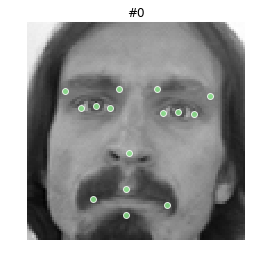

In [12]:
show(data, 0)

In [13]:
def show_random_grid(df, n=5, figsize=(10, 10), h_pad=0.05, w_pad=0.05):
    f, axes = plt.subplots(n, n, figsize=figsize)
    n_images = len(df)
    indexes = np.random.choice(n_images, size=n*n, replace=False)
    for idx, ax in zip(indexes, axes.flat):
        show(df, idx, ax=ax)
    f.tight_layout(h_pad=h_pad, w_pad=w_pad)

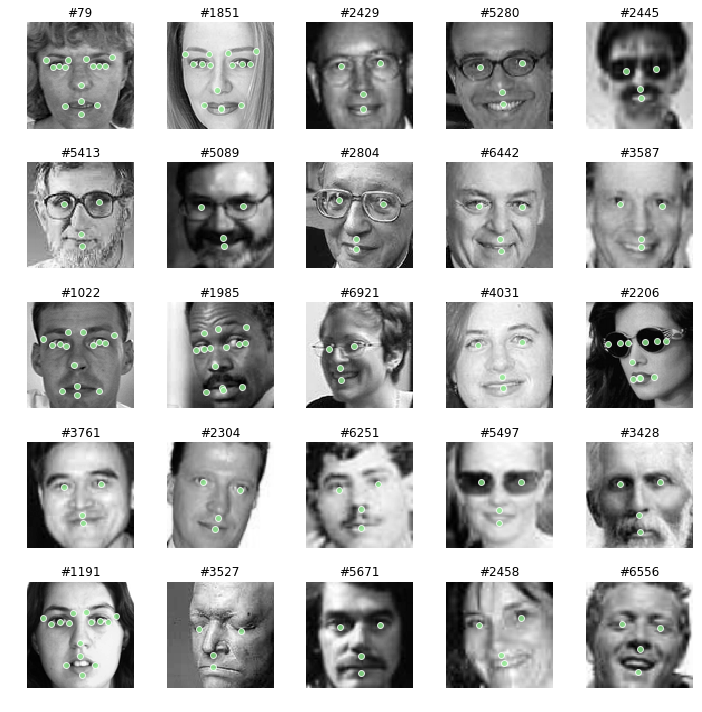

In [14]:
show_random_grid(data)

In [15]:
landmarks = data[data.columns[data.columns != 'Image']]

In [16]:
X = SimpleImputer().fit_transform(landmarks) 
imputed_data = pd.DataFrame(X, columns=landmarks.columns)
imputed_data['Image'] = data.Image

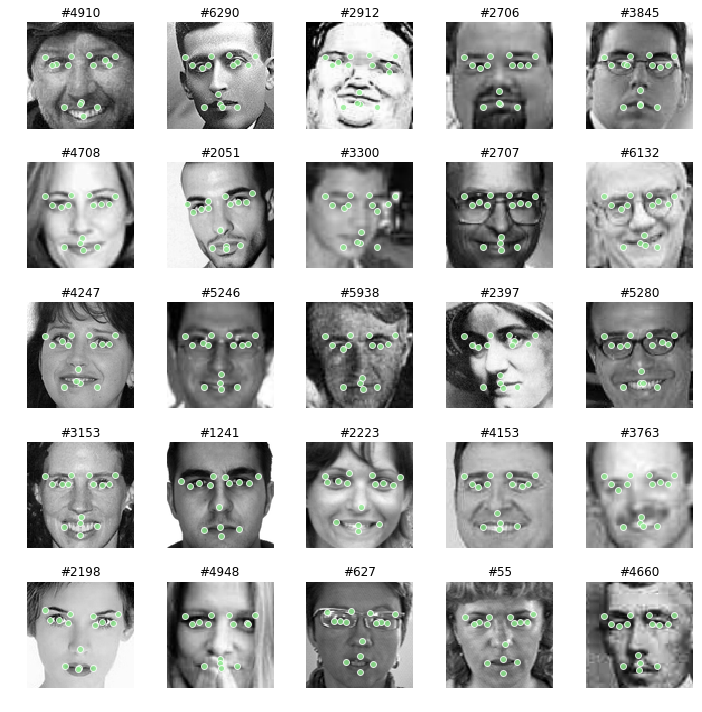

In [17]:
show_random_grid(imputed_data)

In [18]:
import copy
import math

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

from layers import conv, fc, res3x3, bottleneck

In [19]:
X = np.stack(imputed_data.apply(lambda x: create_sample(x, torch_shape), axis=1).values)

In [20]:
y = np.stack(imputed_data.drop(columns='Image').apply(lambda x: create_target(x), axis=1).values)

In [21]:
def create_datasets(X, y, test_size=0.2):
    X_norm = X/255
    scaler = MinMaxScaler(feature_range=(-1, 1))
    y_norm = scaler.fit_transform(y)
    subsets = train_test_split(X_norm, y_norm, test_size=0.2, random_state=seed)
    X_train, X_test, y_train, y_test = [
        torch.tensor(subset, dtype=torch.float32) 
        for subset in subsets]
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_test, y_test)
    return train_ds, valid_ds, scaler

In [22]:
def create_loaders(train_ds, valid_ds, bs=512, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl

In [23]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [24]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [25]:
class SimpleNet(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        self.conv1 = nn.Conv2d(ni, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, no)
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = self.pool(x)
        x = self.fc(x.view(x.size(0), -1))
        return x

In [26]:
class ConvNet(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        layers  = conv(ni,  16, kernel=3, stride=2, pad=1, activ='leaky_relu', bn=True)
        layers += conv(16,  16, kernel=3, stride=1, pad=1, activ='leaky_relu', bn=True)
        layers += conv(16,  32, kernel=3, stride=2, pad=1, activ='leaky_relu', bn=True)
        layers += conv(32,  32, kernel=3, stride=1, pad=1, activ='leaky_relu', bn=True)
        layers += conv(32,  64, kernel=3, stride=2, pad=1, activ='leaky_relu', bn=True)
        layers += conv(64,  64, kernel=3, stride=1, pad=1, activ='leaky_relu', bn=True)
        layers += conv(64, 128, kernel=3, stride=2, pad=1, activ='leaky_relu', bn=True)
        layers += bottleneck()
        layers += fc(256, 128, bn=True, activ='relu')
        layers += fc(128, no, bn=False)
        self.model = nn.ModuleList(layers)
    
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

In [27]:
class ResNet(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        layers = conv(ni, 32, kernel=3, stride=2, pad=1, activ='leaky_relu', bn=True)
        layers += [
            res3x3(3,  32,  32, activ='leaky_relu'),
            res3x3(3,  32,  64, activ='leaky_relu', upsample=True),
            res3x3(3,  64,  64, activ='leaky_relu'),
            res3x3(3,  64, 128, activ='leaky_relu', upsample=True),
            res3x3(3, 128, 128, activ='leaky_relu')]
        layers += bottleneck()
        layers += fc(256, 128, bn=True, activ='relu')
        layers += fc(128, no, bn=False)
        self.model = nn.ModuleList(layers)
    
    def forward(self, x):
        for layer in self.model:
#             if layer.__class__.__name__.startswith('Adaptive'):
#                 breakpoint()
            x = layer(x)
        return x

In [28]:
lr = 1e-2
wd = 1e-5
bs = 800
n_epochs = 1000
patience = 200
no_improvements = 0
jobs = 12
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

trn_ds, val_ds, scaler = create_datasets(X, y)
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs, jobs=jobs)
dataset_sizes = {'train': len(trn_ds), 'val': len(val_ds)}

# net = SimpleNet(1, num_of_landmarks)
# net = ConvNet(1, num_of_landmarks)
net = ResNet(1, num_of_landmarks)
net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = len(trn_dl)
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase, loader in (('train', trn_dl), ('val', val_dl)):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in loader:
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

if best_weights is not None:
    print(f'Loading the best weights with the training loss: {best_loss:.4f}')
    net.load_state_dict(best_weights)

loss improvement on epoch: 1
[001/1000] train: 2.0393 - val: 0.7910
loss improvement on epoch: 2
[002/1000] train: 0.6404 - val: 0.5129
loss improvement on epoch: 3
[003/1000] train: 0.5276 - val: 0.4022
loss improvement on epoch: 4
[004/1000] train: 0.3354 - val: 0.3250
loss improvement on epoch: 5
[005/1000] train: 0.3113 - val: 0.3140
loss improvement on epoch: 6
[006/1000] train: 0.2738 - val: 0.2895
loss improvement on epoch: 7
[007/1000] train: 0.2663 - val: 0.2830
loss improvement on epoch: 8
[008/1000] train: 0.2565 - val: 0.2752
[009/1000] train: 0.2583 - val: 0.2771
loss improvement on epoch: 10
[010/1000] train: 0.2481 - val: 0.2677
[011/1000] train: 0.2480 - val: 0.2719
loss improvement on epoch: 12
[012/1000] train: 0.2421 - val: 0.2650
[013/1000] train: 0.2445 - val: 0.2737
loss improvement on epoch: 14
[014/1000] train: 0.2418 - val: 0.2632
[015/1000] train: 0.2459 - val: 0.2788
loss improvement on epoch: 16
[016/1000] train: 0.2433 - val: 0.2615
[017/1000] train: 0.2439

[173/1000] train: 0.0282 - val: 0.2007
[174/1000] train: 0.0253 - val: 0.1987
[175/1000] train: 0.0269 - val: 0.2022
[176/1000] train: 0.0254 - val: 0.1974
[177/1000] train: 0.0270 - val: 0.2016
[178/1000] train: 0.0253 - val: 0.1965
[179/1000] train: 0.0272 - val: 0.2051
loss improvement on epoch: 180
[180/1000] train: 0.0250 - val: 0.1954
[181/1000] train: 0.0271 - val: 0.2037
loss improvement on epoch: 182
[182/1000] train: 0.0249 - val: 0.1952
[183/1000] train: 0.0260 - val: 0.2026
loss improvement on epoch: 184
[184/1000] train: 0.0240 - val: 0.1951
[185/1000] train: 0.0249 - val: 0.2009
loss improvement on epoch: 186
[186/1000] train: 0.0230 - val: 0.1942
[187/1000] train: 0.0234 - val: 0.2005
[188/1000] train: 0.0225 - val: 0.1959
[189/1000] train: 0.0237 - val: 0.1987
[190/1000] train: 0.0219 - val: 0.1957
[191/1000] train: 0.0241 - val: 0.2002
[192/1000] train: 0.0223 - val: 0.1954
[193/1000] train: 0.0238 - val: 0.1998
[194/1000] train: 0.0223 - val: 0.1944
[195/1000] train: 

[371/1000] train: 0.0092 - val: 0.1941
[372/1000] train: 0.0085 - val: 0.1911
[373/1000] train: 0.0090 - val: 0.1935
[374/1000] train: 0.0088 - val: 0.1909
[375/1000] train: 0.0097 - val: 0.1945
[376/1000] train: 0.0093 - val: 0.1915
[377/1000] train: 0.0096 - val: 0.1953
[378/1000] train: 0.0096 - val: 0.1903
[379/1000] train: 0.0108 - val: 0.1949
[380/1000] train: 0.0107 - val: 0.1906
[381/1000] train: 0.0119 - val: 0.1941
[382/1000] train: 0.0107 - val: 0.1908
[383/1000] train: 0.0129 - val: 0.1937
[384/1000] train: 0.0104 - val: 0.1921
[385/1000] train: 0.0110 - val: 0.1968
[386/1000] train: 0.0103 - val: 0.1918
[387/1000] train: 0.0113 - val: 0.1962
[388/1000] train: 0.0103 - val: 0.1908
[389/1000] train: 0.0121 - val: 0.1985
[390/1000] train: 0.0113 - val: 0.1908
[391/1000] train: 0.0115 - val: 0.1948
[392/1000] train: 0.0105 - val: 0.1911
[393/1000] train: 0.0113 - val: 0.1953
[394/1000] train: 0.0112 - val: 0.1909
[395/1000] train: 0.0114 - val: 0.1936
[396/1000] train: 0.0102 

[574/1000] train: 0.0066 - val: 0.1850
[575/1000] train: 0.0080 - val: 0.1877
[576/1000] train: 0.0079 - val: 0.1857
[577/1000] train: 0.0083 - val: 0.1912
[578/1000] train: 0.0076 - val: 0.1845
[579/1000] train: 0.0083 - val: 0.1889
[580/1000] train: 0.0074 - val: 0.1858
[581/1000] train: 0.0091 - val: 0.1891
[582/1000] train: 0.0078 - val: 0.1844
[583/1000] train: 0.0081 - val: 0.1877
[584/1000] train: 0.0072 - val: 0.1850
[585/1000] train: 0.0073 - val: 0.1872
[586/1000] train: 0.0074 - val: 0.1855
[587/1000] train: 0.0079 - val: 0.1880
[588/1000] train: 0.0076 - val: 0.1852
[589/1000] train: 0.0078 - val: 0.1887
[590/1000] train: 0.0075 - val: 0.1863
[591/1000] train: 0.0084 - val: 0.1883
[592/1000] train: 0.0077 - val: 0.1861
[593/1000] train: 0.0082 - val: 0.1865
[594/1000] train: 0.0074 - val: 0.1857
[595/1000] train: 0.0084 - val: 0.1883
[596/1000] train: 0.0074 - val: 0.1853
[597/1000] train: 0.0077 - val: 0.1867
[598/1000] train: 0.0079 - val: 0.1876
[599/1000] train: 0.0085 

[778/1000] train: 0.0064 - val: 0.1814
[779/1000] train: 0.0070 - val: 0.1849
[780/1000] train: 0.0065 - val: 0.1819
[781/1000] train: 0.0064 - val: 0.1845
[782/1000] train: 0.0056 - val: 0.1809
[783/1000] train: 0.0065 - val: 0.1828
[784/1000] train: 0.0054 - val: 0.1811
[785/1000] train: 0.0059 - val: 0.1839
[786/1000] train: 0.0053 - val: 0.1822
[787/1000] train: 0.0067 - val: 0.1845
[788/1000] train: 0.0065 - val: 0.1822
[789/1000] train: 0.0095 - val: 0.1880
[790/1000] train: 0.0091 - val: 0.1833
[791/1000] train: 0.0088 - val: 0.1859
[792/1000] train: 0.0074 - val: 0.1821
[793/1000] train: 0.0076 - val: 0.1852
[794/1000] train: 0.0067 - val: 0.1819
[795/1000] train: 0.0069 - val: 0.1827
[796/1000] train: 0.0060 - val: 0.1821
[797/1000] train: 0.0074 - val: 0.1826
[798/1000] train: 0.0061 - val: 0.1817
[799/1000] train: 0.0068 - val: 0.1867
[800/1000] train: 0.0064 - val: 0.1816
[801/1000] train: 0.0068 - val: 0.1824
[802/1000] train: 0.0060 - val: 0.1811
[803/1000] train: 0.0064 

[985/1000] train: 0.0063 - val: 0.1809
[986/1000] train: 0.0064 - val: 0.1804
[987/1000] train: 0.0068 - val: 0.1837
loss improvement on epoch: 988
[988/1000] train: 0.0062 - val: 0.1791
[989/1000] train: 0.0060 - val: 0.1826
[990/1000] train: 0.0058 - val: 0.1808
[991/1000] train: 0.0073 - val: 0.1820
[992/1000] train: 0.0061 - val: 0.1805
[993/1000] train: 0.0072 - val: 0.1824
[994/1000] train: 0.0065 - val: 0.1808
[995/1000] train: 0.0068 - val: 0.1809
[996/1000] train: 0.0057 - val: 0.1803
[997/1000] train: 0.0069 - val: 0.1851
[998/1000] train: 0.0059 - val: 0.1799
[999/1000] train: 0.0061 - val: 0.1844
[1000/1000] train: 0.0053 - val: 0.1797
Loading the best weights with the training loss: 0.1791


In [29]:
def np_clone(t):
    return t.clone().detach().cpu().numpy()

In [30]:
def predict(model, dataset, i, img_sz=img_sz, device=device, scaler=scaler):
    test_img, test_pts = dataset[i]
    model.train(False)
    [pred] = model(test_img[None].to(device))
    model.train(True)
    np_pts = np_clone(pred)
    np_pts = scaler.inverse_transform(np_pts.reshape(1, -1)).flatten()
    np_img = np_clone(test_img).transpose(1, 2, 0).reshape(96, 96)
    np_img *= 255
    np_img = np_img.astype(np.uint8)
    rescaled_test_pts = scaler.inverse_transform(test_pts.reshape(1, -1)).flatten()
    return np_pts, (np_img, rescaled_test_pts)

In [31]:
def show_predictions(model, dataset, n, figsize=(10, 10)):
    f, axes = plt.subplots(n, n, figsize=figsize)
    n_samples = len(dataset)
    indexes = np.random.choice(n_samples, size=n*n, replace=False)
    for ax, idx in zip(axes.flat, indexes):
        pred_pts, (test_img, test_pts) = predict(model, dataset, idx)
        ax.imshow(test_img, cmap='gray')
        ax.scatter(*split(test_pts), color='lightgreen', edgecolor='white', s=50, alpha=0.8, 
                   label='gt')
        ax.scatter(*split(pred_pts), color='red', marker='x', s=20, label='predicted')
        ax.set_axis_off()
    handles, labels = axes.flat[0].get_legend_handles_labels()
    f.legend(handles, labels, loc='upper center', fontsize=16)
    f.suptitle

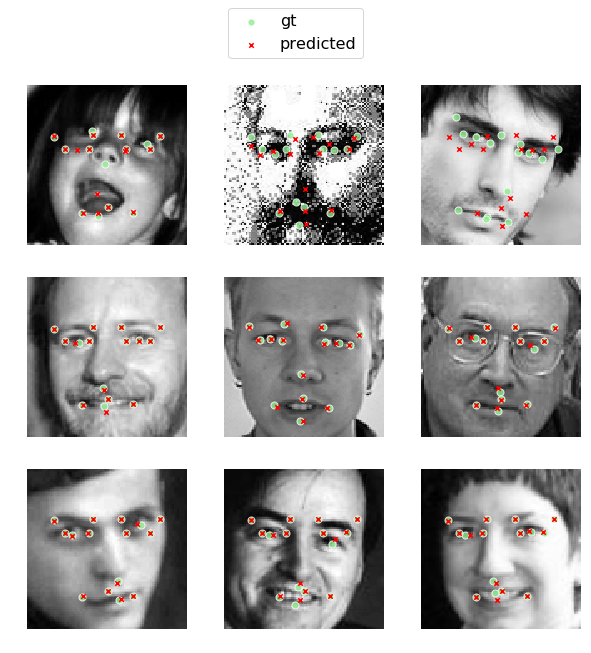

In [32]:
show_predictions(net, val_ds, 3)